In [77]:
df_1 = pd.read_csv('C:/Users/mi-bi/OneDrive/바탕 화면/data Row/5years_kospi.csv', index_col=0)
df_2 = pd.read_csv('C:/Users/mi-bi/OneDrive/바탕 화면/data Row/5years_kosdaq.csv', index_col=0)
df_raw = pd.concat([df_1,df_2],ignore_index=True)

#### Making Market Timming

In [78]:
import pandas as pd

In [79]:
def making_mt(start,end,code):
    from pykrx import stock
    df = stock.get_index_fundamental(start,end,code)
    df = df.drop(['등락률','PER','선행PER','PBR','배당수익률'],axis=1)
    
    ''' code : KOSPI ('1001') KOSDAQ ('2001') '''
    if code=='1001': 
        df['sma20'] = df['종가'].rolling(20).mean()
        df['mt'] = df['종가']>df['sma20']
        df = df.dropna()
        return df
    elif code=='2001':     
        df['sma3'] = df['종가'].rolling(3).mean()
        df['sma5'] = df['종가'].rolling(5).mean()
        df['sma10'] = df['종가'].rolling(10).mean()
        df['mt'] = ((df['종가']>df['sma3'])|(df['종가']>df['sma5'])|(df['종가']>df['sma10']))
        df = df.dropna()
        return df
    else:
        print('올바른 종목 code 입력')

In [80]:
def making_mt_plot(df,code):
    import matplotlib.pyplot as plt
    from matplotlib import dates
    if code=='1001': 
        plt.figure(figsize = (50, 10))
        plt.title("Kospi Market timming")
        plt.plot(df["종가"])
        plt.plot(df['sma20'])
        plt.scatter(df.loc[df['mt']==1].index, df['종가'][df['mt']==1],
                    color = 'red',
                    label='Go',
                    marker ='^',
                    alpha=0.8)
        plt.scatter(df.loc[df['mt']==0].index, df['종가'][df['mt']==0],
                    color = 'blue',
                    label='Stop',
                    marker ='v',
                    alpha=0.8)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    elif code=='2001':
        plt.figure(figsize = (50, 10))
        plt.title("Kosdaq Market timming")
        plt.plot(df["종가"])
        plt.plot(df['sma3'])
        plt.plot(df['sma5'])
        plt.plot(df['sma10'])
        plt.scatter(df.loc[df['mt']==1].index, df['종가'][df['mt']==1],
                    color = 'red',
                    label='Go',
                    marker ='^',
                    alpha=0.8)
        plt.scatter(df.loc[df['mt']==0].index, df['종가'][df['mt']==0],
                    color = 'blue',
                    label='Stop',
                    marker ='v',
                    alpha=0.8)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    else:
        print('Error : Code check')
    

## 설명 
* backtest 시작 , 끝날짜를 for 문으로 돌린다 ex) for i in range(start,end)  
* 시작 날짜에 maket Timming 이 true면 아래전략 시행  
* sort_vol = 시작 날짜 누적거래대금 범위에 속하는 종목 df로만든다.  output : df_vol
* search momentum signal = df_vol과 df_raw 를 활용하여 Momentum 값을 계산하고 signal을 만든다 
* True 인 종목을 매수한다. 현금계좌잔고 감소 , 보유잔고 증가 (주가*수량)  

<익일>  
* 다음날 보유잔고에 매도 조건을 확인한다 매도조건이 True이면 매도한다. 현금계좌잔고 증가 (당일 종가 * 수량) 보유잔고 감소  
* 매도 후 전일과 같이 위 과정을 반복  

<최종>  
* 수익률 출력  
* MDD 출력 (이전략으로 매매를 했을때 최대 몇% 까지 손실을 보았었는가)  
* 샤프지수출력 (이 전략이아니라 그냥 지수에 투자했을 때에 비해 변동성이 얼마나 큰가 )
* 승률 (이전략을 했을때 + 수익을 본횟수 / 전체횟수)  
* log (활용 무궁무진 : 매수 매도 기록을 전부기록 추후 확률 통계에 기반이됨)  

<고급>
* momentum 지수가 몇일 때 매수를 하면 다음날 상승확률이 가장 높은지 통계적검증 해서 파라미터 조정가능 


#### Making 거래대금조회


In [81]:
def sort_vol(df,date,range):
    df = df[(df['누적거래대금']>=range)&(df['날짜']==date)]
    return df

#### Momentum Search

In [82]:
def search_momentum_signal(df_vol, df_raw):
    li = df_vol['종목명'].values
    dt = df_vol['날짜'].values[0]
    df_vol['Buy'] = None
    df_vol['momentum'] = None
    for i in li:
        today_idx = df_raw[(df_raw['종목명']==i)&(df_raw['날짜']==dt)].index
        day5_idx = df_raw[(df_raw['종목명']==i)&(df_raw['날짜']==dt)].index-5
        momentum = df_raw.loc[today_idx]['종가'].values/df_raw.loc[day5_idx]['종가'].values
        df_vol.loc[df_vol['종목명']==i,'momentum']=momentum[0]
        df_vol.loc[df_vol['종목명']==i,'Buy']=df_vol['momentum']>=1
    return df_vol
        

#### buy signal True 인 종목 매수후 +5일뒤 매도 

In [249]:
df_vol = sort_vol(df_raw,20220104,10000000000)

In [250]:
df_mom = search_momentum_signal(df_vol, df_raw)

C:\Users\mi-bi\AppData\Local\Temp\ipykernel_37524\838232746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vol['Buy'] = None
C:\Users\mi-bi\AppData\Local\Temp\ipykernel_37524\838232746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vol['momentum'] = None


<AxesSubplot: >

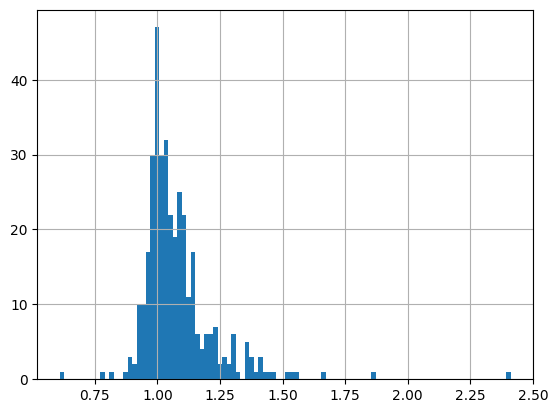

In [251]:
df_mom['momentum'].hist(bins=100)

In [252]:
def buy_list(df_mom):
    buy_list = df_mom[df_mom['Buy']==True]
    return buy_list
    

In [253]:
b_li = buy_list(df_mom)

In [254]:
b_li.head(1)

,날짜,종가,시가,최고가,최저가,누적거래량,누적거래대금,종목명,Buy,momentum
998,20220104,161900,168500,168600,161200,254928,41761768500,LX세미콘,True,1.009981


In [255]:
for i in b_li['종목명'].unique():
    idx = b_li[b_li['종목명']==i].index
    b_li.loc[b_li['종목명']==i,'5일후종가']=df_raw[(df_raw['종목명']==i)&(df_raw.index==idx[0]+5)]['종가'].values[0]
    

C:\Users\mi-bi\AppData\Local\Temp\ipykernel_37524\650286458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_li.loc[b_li['종목명']==i,'5일후종가']=df_raw[(df_raw['종목명']==i)&(df_raw.index==idx[0]+5)]['종가'].values[0]


In [256]:
b_li['수익률'] = (b_li['5일후종가']-b_li['종가'])/b_li['종가']*100

C:\Users\mi-bi\AppData\Local\Temp\ipykernel_37524\3609460801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b_li['수익률'] = (b_li['5일후종가']-b_li['종가'])/b_li['종가']*100


In [257]:
b_li.sort_values(by='수익률')

,날짜,종가,시가,최고가,최저가,누적거래량,누적거래대금,종목명,Buy,momentum,5일후종가,수익률
1481169,20220104,2445,2495,2520,2425,10416530,25795039285,휴센텍,True,1.042644,1605.0,-34.355828
1017966,20220104,17375,17000,18300,16600,7267058,126805747700,엔비티,True,1.463158,12525.0,-27.913669
2384854,20220104,6000,5270,6320,5240,45570552,266208863710,경남스틸,True,1.411765,4545.0,-24.250000
1494512,20220104,1971,1921,2238,1904,11383701,23366773650,스튜디오산타클로스,True,1.087748,1528.0,-22.475901
1180542,20220104,34600,31700,38450,31700,14985964,535074410650,로보티즈,True,1.527594,27400.0,-20.809249
...,...,...,...,...,...,...,...,...,...,...,...,...
2301157,20220104,4320,4050,4320,3890,8021525,33522043255,오픈베이스,True,1.210084,5250.0,21.527778
1852347,20220104,7290,5720,7290,5630,7602662,50730411490,알에프세미,True,1.410058,9070.0,24.417010
1176422,20220104,44600,40600,45050,40600,383258,16751062600,대보마그네틱,True,1.133418,56000.0,25.560538
1259190,20220104,19300,17750,19650,17750,1602748,30454795150,엠플러스,True,1.198758,25050.0,29.792746


In [262]:
b_li['수익률'].mean()

-5.786643205327776